In [48]:
import os
import random

from google.cloud import storage
import tensorflow.compat.v1 as tf

# CONFIG
project = "Waymo3DObjectDetection"
bucket_name = 'waymo_open_dataset_v_1_2_0_individual_files'
suffix = '.tfrecord'
data_destination = os.getcwd() + "/data/"
download_batch_size = 1

def partition(list_in, n):
    random.shuffle(list_in)
    return [list_in[i::n] for i in range(n)]

def download_batch(blobs, batch_num=0):
    fnames = []
    for c, blob in enumerate(blobs):
        fname = f"{data_destination}batch_{batch_num}file_{c}{suffix}"
        print(blob)
        blob.download_to_filename(fname)
        fnames.append(fname)
    return fnames

# Initialise a client
storage_client = storage.Client(project= project) #storage.Client(project= "Waymo3DObjectDetection", credentials=credentials)
# Create a bucket object for our bucket
bucket = storage_client.get_bucket(bucket_name)
# Get blob files in bucket
files = [blob for blob in storage_client.list_blobs(bucket_name, prefix='training/')]
# Partition files into batches
# batch_num = int(len(files)/download_batch_size)
# batches = partition(files, batch_num)

# Eventually will look like this
# for c, batch in enumerate(batches):
#     fnames = download_batch(batch, c)
#     dataset = tf.data.TFRecordDataset(fname, compression_type='')
    # DO SOMETHING


/usr/local/lib/python3.6/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [49]:
import os
import tensorflow.compat.v1 as tf
import math
import numpy as np
import itertools

tf.enable_eager_execution()

from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

In [50]:
### For now let's just play around with one sample and see wasssup

# Download file into data folder
import time
start = time.time()
fname = download_batch(files[:7])
end = time.time()
print(end-start)

<Blob: waymo_open_dataset_v_1_2_0_individual_files, training/segment-10017090168044687777_6380_000_6400_000_with_camera_labels.tfrecord, 1584220227553449>
<Blob: waymo_open_dataset_v_1_2_0_individual_files, training/segment-10023947602400723454_1120_000_1140_000_with_camera_labels.tfrecord, 1584220259472875>
<Blob: waymo_open_dataset_v_1_2_0_individual_files, training/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord, 1584220288545174>
<Blob: waymo_open_dataset_v_1_2_0_individual_files, training/segment-10061305430875486848_1080_000_1100_000_with_camera_labels.tfrecord, 1584220328559019>
<Blob: waymo_open_dataset_v_1_2_0_individual_files, training/segment-10072140764565668044_4060_000_4080_000_with_camera_labels.tfrecord, 1584220354864522>
<Blob: waymo_open_dataset_v_1_2_0_individual_files, training/segment-10072231702153043603_5725_000_5745_000_with_camera_labels.tfrecord, 1584220379143471>
<Blob: waymo_open_dataset_v_1_2_0_individual_files, training/segment-10

In [10]:
# Load into tf record dataset
dataset = tf.data.TFRecordDataset(fname, compression_type='')
# Retrieve frame
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    break


<TFRecordDatasetV1 shapes: (), types: tf.string>

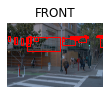

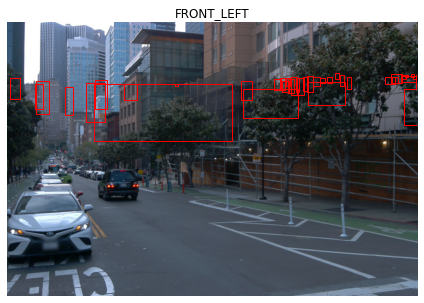

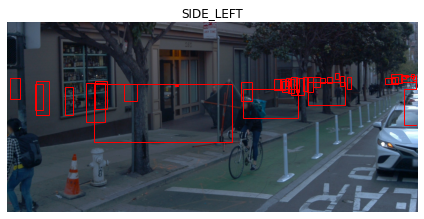

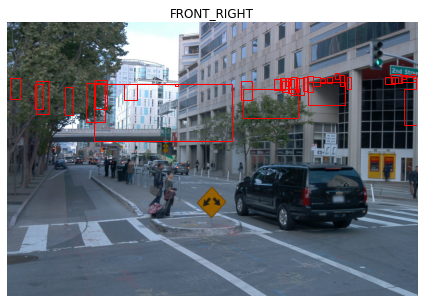

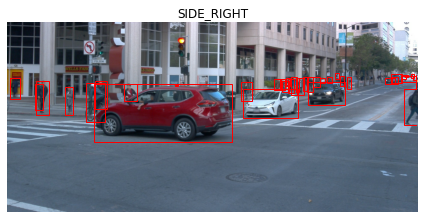

<Figure size 1800x1440 with 0 Axes>

In [5]:
# Visualise images
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_camera_image(camera_image, camera_labels, layout, cmap=None):
    """Show a camera image and the given camera labels."""

    ax = plt.subplot(*layout)

    # Draw the camera labels.
    for camera_labels in frame.camera_labels:
        # Ignore camera labels that do not correspond to this camera.
        if camera_labels.name != camera_image.name:
            continue

    # Iterate over the individual labels.
    for label in camera_labels.labels:
        # Draw the object bounding box.
        ax.add_patch(patches.Rectangle(
        xy=(label.box.center_x - 0.5 * label.box.length,
            label.box.center_y - 0.5 * label.box.width),
        width=label.box.length,
        height=label.box.width,
        linewidth=1,
        edgecolor='red',
        facecolor='none'))

    # Show the camera image.
    plt.imshow(tf.image.decode_jpeg(camera_image.image), cmap=cmap)
    plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
    plt.grid(False)
    plt.axis('off')

    plt.figure(figsize=(25, 20))

for index, image in enumerate(frame.images):
    show_camera_image(image, frame.camera_labels, [3, 3, index+1])

In [35]:
# Box coords
frame.camera_labels[0]

name: FRONT
labels {
  box {
    center_x: 1052.4264293723936
    center_y: 251.37282
    width: 17.68452000000002
    length: 11.368619999999964
  }
  type: TYPE_PEDESTRIAN
  id: "00327d58-6dbf-4f67-b8e3-5b83ddb67fc0"
}
labels {
  box {
    center_x: 844.4358300000001
    center_y: 279.16278
    width: 13.894979999999975
    length: 15.789750000000026
  }
  type: TYPE_VEHICLE
  id: "037eb3ee-49d8-4667-8273-0d1abeacea02"
}
labels {
  box {
    center_x: 588.2198543948161
    center_y: 297.9005535032399
    width: 28.421550000000025
    length: 55.99868668768829
  }
  type: TYPE_VEHICLE
  id: "0547d337-1057-4336-94a6-dd0016615222"
}
labels {
  box {
    center_x: 932.85843
    center_y: 186.83575180261528
    width: 8.84226000000001
    length: 12.631799999999998
  }
  type: TYPE_VEHICLE
  id: "0cd1bfd1-fb71-470d-838d-8303f8b249f5"
  detection_difficulty_level: LEVEL_2
  tracking_difficulty_level: LEVEL_2
}
labels {
  box {
    center_x: 562.74669
    center_y: 306.32115
    width: 28.4

In [34]:
#### Here's how to access the tensor, then we can convert to pytorch
tf.image.decode_jpeg(frame.images[0].image)

<tf.Tensor: shape=(1280, 1920, 3), dtype=uint8, numpy=
array([[[ 65,  77,  89],
        [ 66,  78,  90],
        [ 67,  79,  91],
        ...,
        [ 80,  87,  95],
        [ 82,  89,  97],
        [ 84,  91,  99]],

       [[ 64,  76,  88],
        [ 65,  77,  89],
        [ 66,  78,  90],
        ...,
        [ 77,  84,  92],
        [ 79,  86,  94],
        [ 81,  88,  96]],

       [[ 68,  80,  92],
        [ 67,  79,  91],
        [ 67,  79,  91],
        ...,
        [ 81,  85,  96],
        [ 80,  87,  95],
        [ 82,  89,  97]],

       ...,

       [[ 86,  93, 103],
        [ 86,  93, 103],
        [ 86,  93, 103],
        ...,
        [ 92, 103, 109],
        [ 88, 101, 107],
        [ 85,  98, 104]],

       [[ 85,  92, 102],
        [ 86,  93, 103],
        [ 87,  94, 104],
        ...,
        [ 92, 103, 109],
        [ 89, 102, 108],
        [ 86,  99, 105]],

       [[ 84,  91, 101],
        [ 84,  91, 101],
        [ 86,  93, 103],
        ...,
        [ 90, 101, 

In [18]:
dir(frame.images[0])

['ByteSize',
 'Clear',
 'ClearExtension',
 'ClearField',
 'CopyFrom',
 'DESCRIPTOR',
 'DiscardUnknownFields',
 'Extensions',
 'FindInitializationErrors',
 'FromString',
 'HasExtension',
 'HasField',
 'IsInitialized',
 'ListFields',
 'MergeFrom',
 'MergeFromString',
 'ParseFromString',
 'RegisterExtension',
 'SerializePartialToString',
 'SerializeToString',
 'SetInParent',
 'UnknownFields',
 'WhichOneof',
 '_CheckCalledFromGeneratedFile',
 '_SetListener',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '_extensions_by_name',
 '_extensions_by_number',
 'camera_readout_done_time',
 'camera_trigger_time',
 'image',
 'name

In [30]:
frame.

AttributeError: Cannot delete field attribute

In [64]:
len(files)

798